In [75]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

In [76]:
load_dotenv()
API_URL = os.getenv('API_URL')      
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')

In [77]:
visits_response = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END}).json()
reg_response = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END}).json()

In [78]:
os.makedirs("./charts", exist_ok=True)

In [96]:
visits_df = pd.DataFrame(visits_response)
reg_df = pd.DataFrame(reg_response)
ads_df = pd.read_csv('./ads.csv')

In [80]:
visits_df['datetime'] = pd.to_datetime(visits_df['datetime'])
reg_df['datetime'] = pd.to_datetime(reg_df['datetime'])
visits_df = visits_df[~visits_df["user_agent"].str.contains("bot", case=False, na=False)]
visits_df = visits_df.sort_values('datetime').drop_duplicates(subset='visit_id', keep='last')
visits_df['date_group'] = visits_df['datetime'].dt.date
reg_df['date_group'] = reg_df['datetime'].dt.date
agg_visits = (
    visits_df.groupby(["date_group", "platform"])
    .size()
    .reset_index(name="visits")
)

agg_regs = (
    reg_df.groupby(["date_group", "platform"])
    .size()
    .reset_index(name="registrations")
)
df_result = pd.merge(
    agg_visits, agg_regs,
    on=["date_group", "platform"],
    how="outer"
).fillna(0)
df_result["conversion"] = (df_result["registrations"] / df_result["visits"]) * 100
df_result = df_result.sort_values("date_group").reset_index(drop=True)
df_result.to_json('./conversion.json')

In [81]:
ads_df['date'] = pd.to_datetime(ads_df['date'])
ads_df['group_date'] = ads_df['date'].dt.date
agg_ads = (ads_df.groupby(['group_date', 'utm_campaign'])["cost"]
    .sum().reset_index())

In [82]:
conv_ads_df = pd.merge(
    df_result, agg_ads,
    left_on=['date_group'],
    right_on=['group_date'],
    how='left').fillna({"cost": 0, "utm_campaign": "none"})
conv_ads_df = conv_ads_df.drop(columns=['group_date'])
conv_ads_df = conv_ads_df.sort_values('date_group').reset_index(drop=True)


In [83]:
conv_ads_df.to_json('./ads.json')

Итоговые визиты


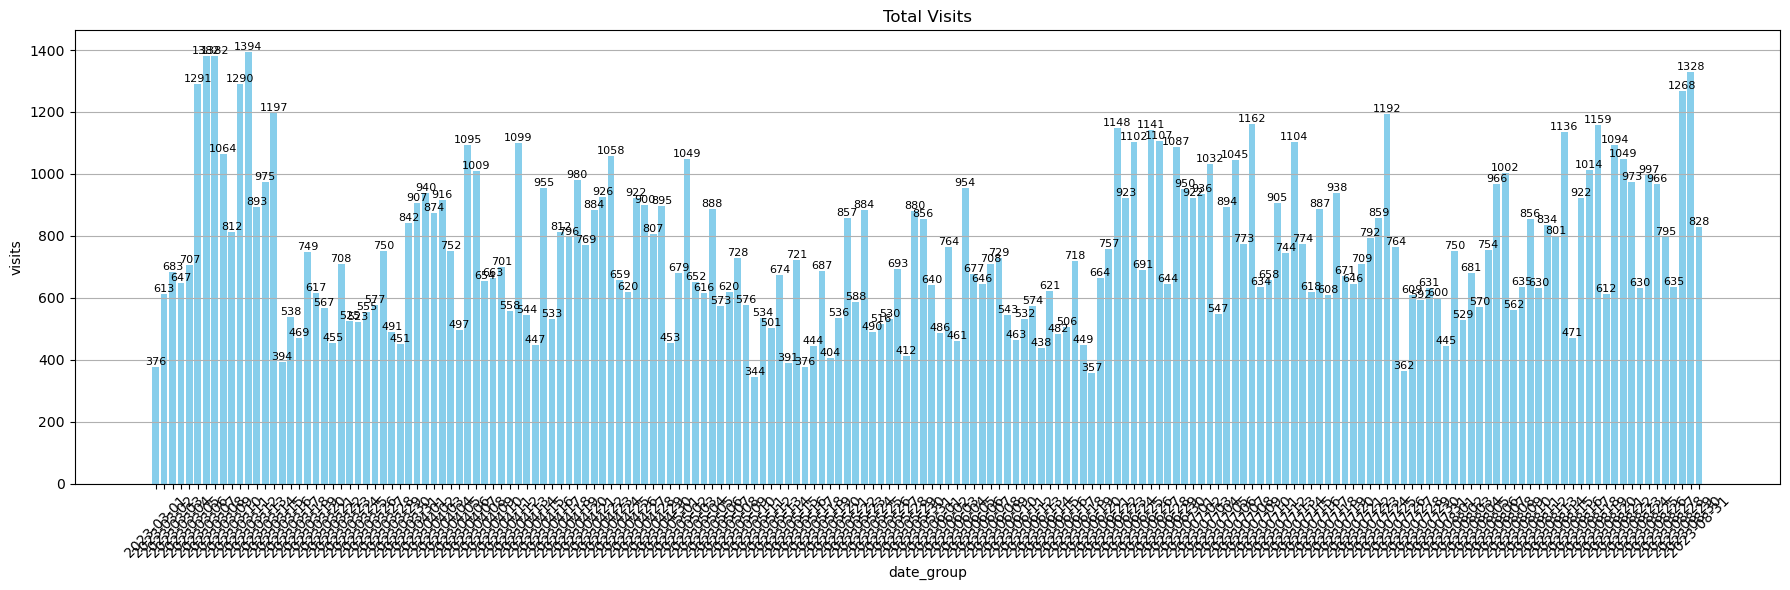

In [84]:
group_for_plot_visits=conv_ads_df.groupby(['date_group'], as_index=False)['visits'].sum()
plt.figure(figsize=(18,6))
plt.bar(group_for_plot_visits['date_group'], group_for_plot_visits['visits'], color = 'skyblue')
for x, y in zip(group_for_plot_visits["date_group"], group_for_plot_visits["visits"]):
    plt.text(x, y, str(int(y)), ha='center', va='bottom', fontsize=8)
plt.title('Total Visits')
plt.xlabel('date_group')
plt.ylabel("visits")
plt.xticks(group_for_plot_visits["date_group"], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('./charts/visits_total.png') 
print('Итоговые визиты')
plt.show()

Итоговые визиты с разбивкой по платформам


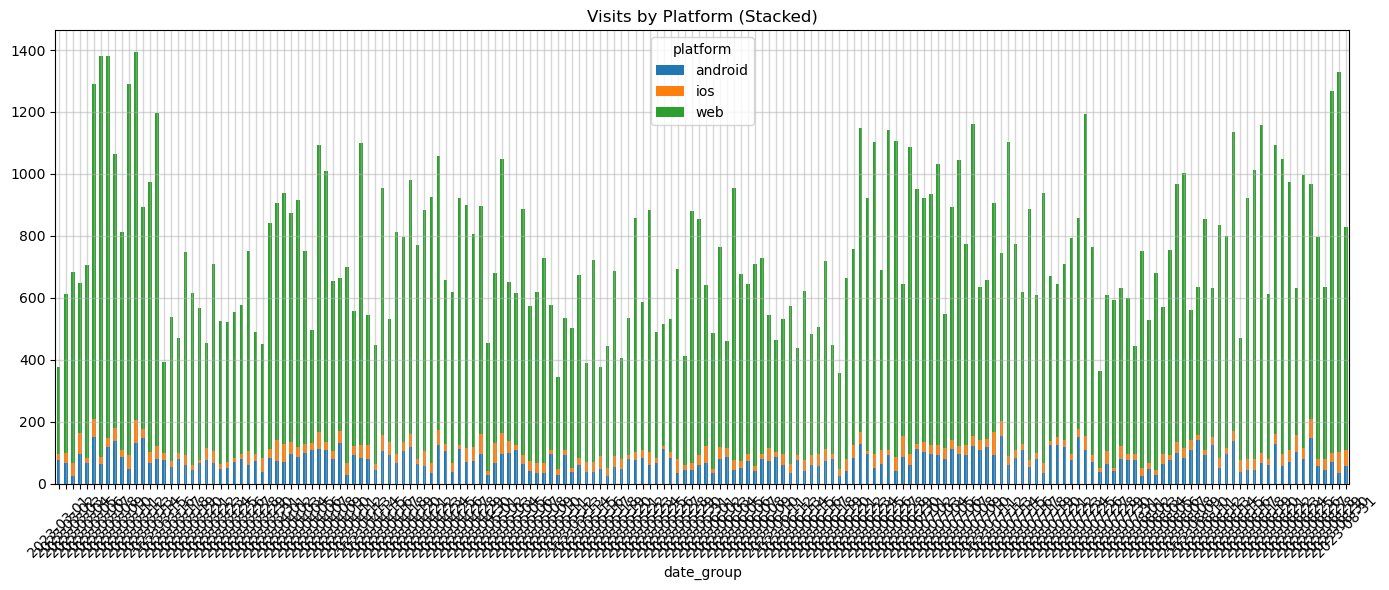

In [85]:
visits_by_platform = df_result.groupby(["date_group", "platform"])["visits"].sum().unstack(fill_value=0)
ax = visits_by_platform.plot(kind="bar", stacked=True, figsize=(14, 6))
plt.title("Visits by Platform (Stacked)")
plt.xlabel("date_group")
plt.xticks(range(len(visits_by_platform.index)), visits_by_platform.index, rotation=45)
plt.grid(alpha=0.5, linewidth=1.0)
plt.tight_layout()
plt.savefig('./charts/visits_by_platform.png')
print('Итоговые визиты с разбивкой по платформам')
plt.show()

Итоговые регистрации


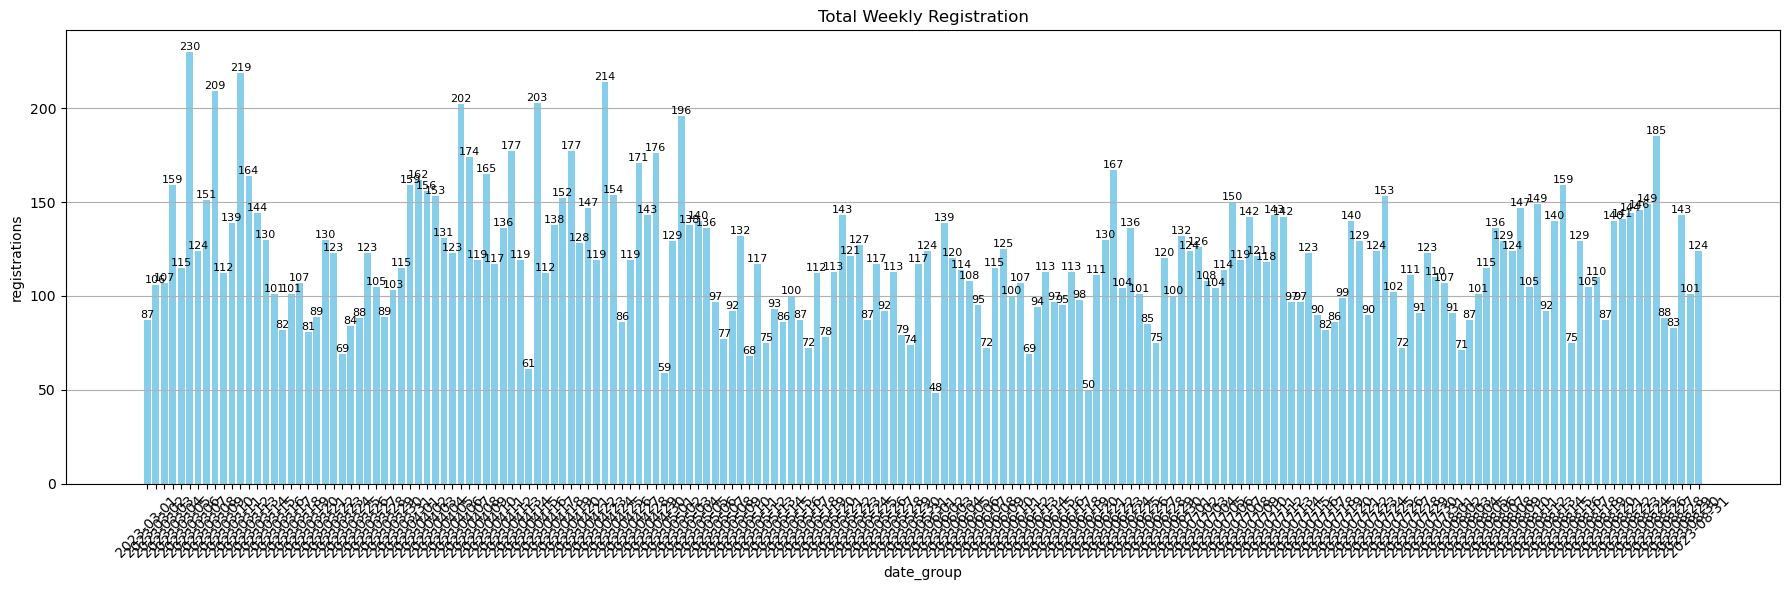

In [86]:
group_for_plot_regs=conv_ads_df.groupby(['date_group'], as_index=False)['registrations'].sum()
plt.figure(figsize=(18,6))
plt.bar(group_for_plot_regs['date_group'], group_for_plot_regs['registrations'], color='skyblue')
for x, y in zip(group_for_plot_regs['date_group'], group_for_plot_regs['registrations']):
    plt.text(x, y, str(int(y)), ha='center', va='bottom', fontsize=8)
plt.title('Total Weekly Registration')
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.xticks(group_for_plot_regs['date_group'], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('./charts/registrations_total.png') 
print('Итоговые регистрации')
plt.show()

Итоговые регистрации с разбивкой по платформе


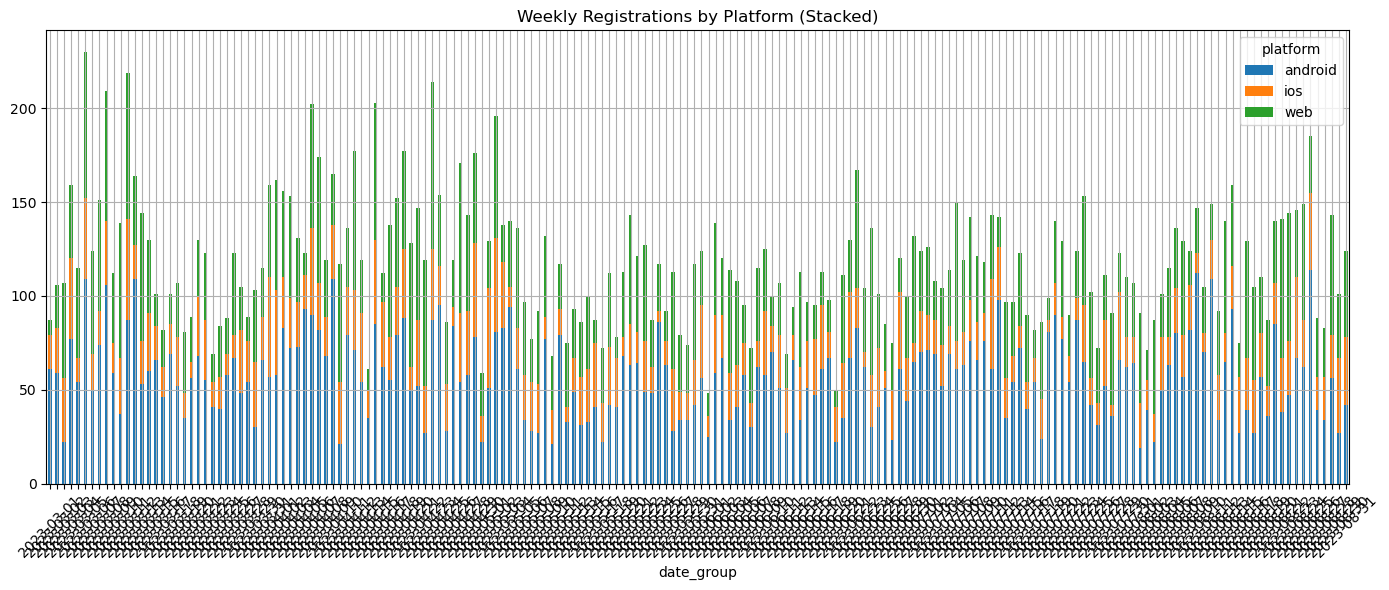

In [87]:
regs_by_platform=df_result.groupby(['date_group', 'platform'])['registrations'].sum().unstack(fill_value=0)
ax=regs_by_platform.plot(kind='bar', stacked=True, figsize=(14,6))
plt.title("Weekly Registrations by Platform (Stacked)")
plt.xlabel('date_group')
plt.xticks(range(len(regs_by_platform.index)), regs_by_platform.index, rotation=45)
plt.grid()
plt.tight_layout()
plt.savefig("./charts/registrations_by_platform.png")
print('Итоговые регистрации с разбивкой по платформе')
plt.show()

Итоговая конверсия


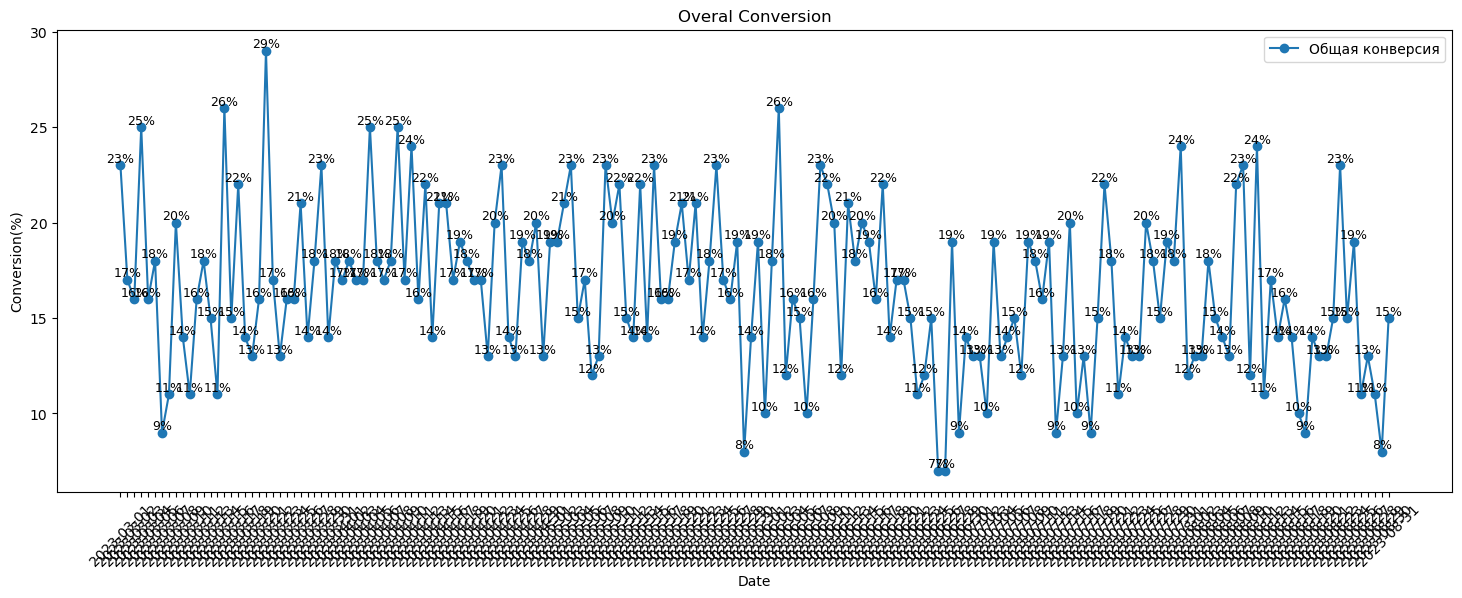

In [88]:
agg_visits_for_plot = (
    visits_df.groupby(["date_group"])
    .size()
    .reset_index(name="visits")
)

agg_regs_for_plot = (
    reg_df.groupby(["date_group"])
    .size()
    .reset_index(name="registrations")
)
df_result_for_plot = pd.merge(
    agg_visits_for_plot, agg_regs_for_plot,
    on=["date_group"],
    how="outer"
).fillna(0)
df_result_for_plot["conversion"] = ((df_result_for_plot["registrations"] / df_result_for_plot["visits"]) * 100).round(0)
df_result_for_plot = df_result_for_plot.sort_values("date_group").reset_index(drop=True)
plt.figure(figsize=(18,6))
plt.plot(df_result_for_plot['date_group'], df_result_for_plot["conversion"], marker='o', label='Общая конверсия')
for x, y in zip(df_result_for_plot['date_group'], df_result_for_plot["conversion"]):
    plt.text(x, y, f"{int(y)}%", ha='center', va='bottom', fontsize=9)
plt.legend()
plt.title('Overal Conversion')
plt.xlabel('Date')
plt.ylabel('Conversion(%)')
plt.xticks(df_result_for_plot['date_group'], rotation=45)
plt.savefig("./charts/overal_conversion.png")
print('Итоговая конверсия')
plt.show()

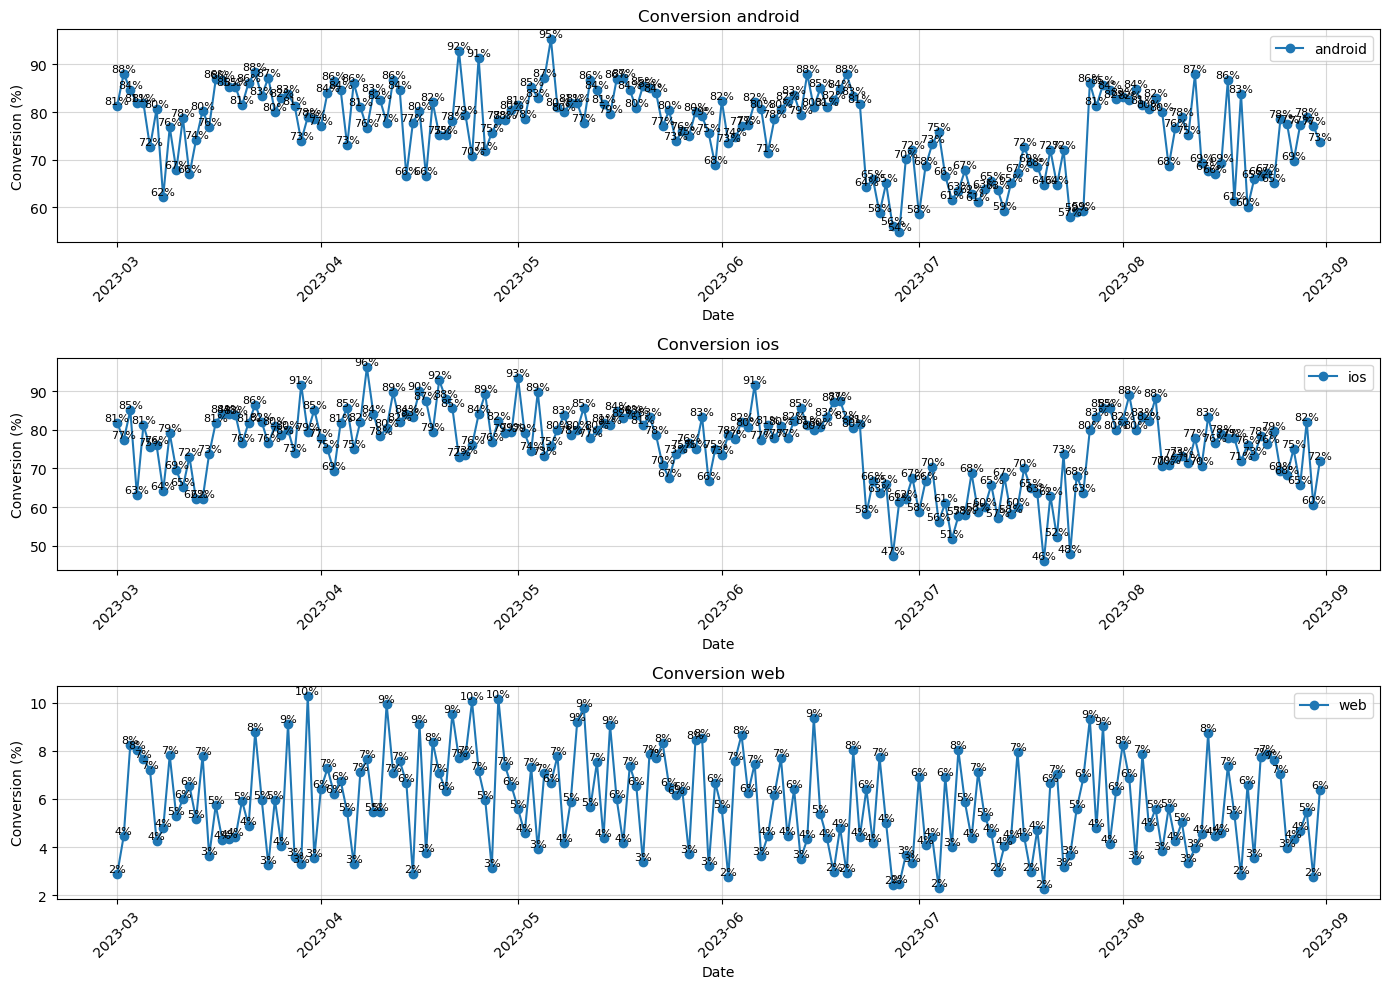

In [89]:
conv_by_platform = df_result.pivot(
    index='date_group',
    columns='platform',
    values='conversion'
).fillna(0)
plt.figure(figsize=(14,10))
for i, col in enumerate(conv_by_platform.columns, start=1):
    plt.subplot(len(conv_by_platform.columns), 1, i)
    plt.plot(conv_by_platform.index, conv_by_platform[col], marker='o', label=col)
    for j in range(len(conv_by_platform)):
        x = conv_by_platform.index[j]
        y = conv_by_platform[col].iloc[j]
        plt.text(x, y, f"{int(y)}%", ha='center', va='bottom', fontsize=8)
    plt.title(f"Conversion {col}")
    plt.xlabel("Date")
    plt.ylabel("Conversion (%)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig("./charts/conversion_by_platform_subplots.png")
plt.show()


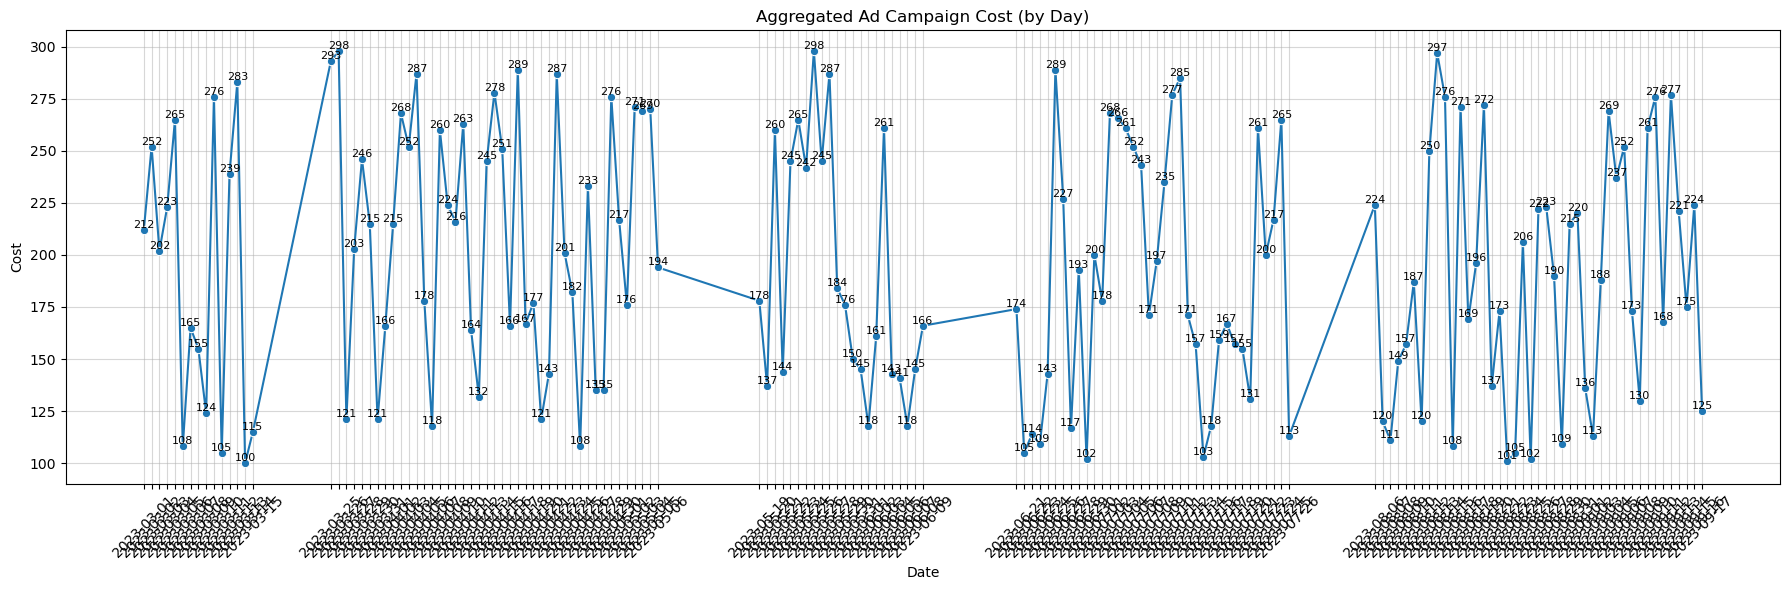

In [90]:
ads_by_date = ads_df.groupby('group_date', as_index=False)['cost'].sum()
plt.figure(figsize=(18,6))
sns.lineplot(data=ads_by_date, x='group_date', y='cost', marker='o')
for x, y in zip(ads_by_date['group_date'], ads_by_date['cost']):
    plt.text(x, y, str(int(y)), ha='center', va='bottom', fontsize=8)
plt.title('Aggregated Ad Campaign Cost (by Day)')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.xticks(ads_by_date['group_date'], [d.strftime('%Y-%m-%d') for d in ads_by_date['group_date']], rotation=45)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('./charts/ads_costs_seaborn.png')
plt.show()

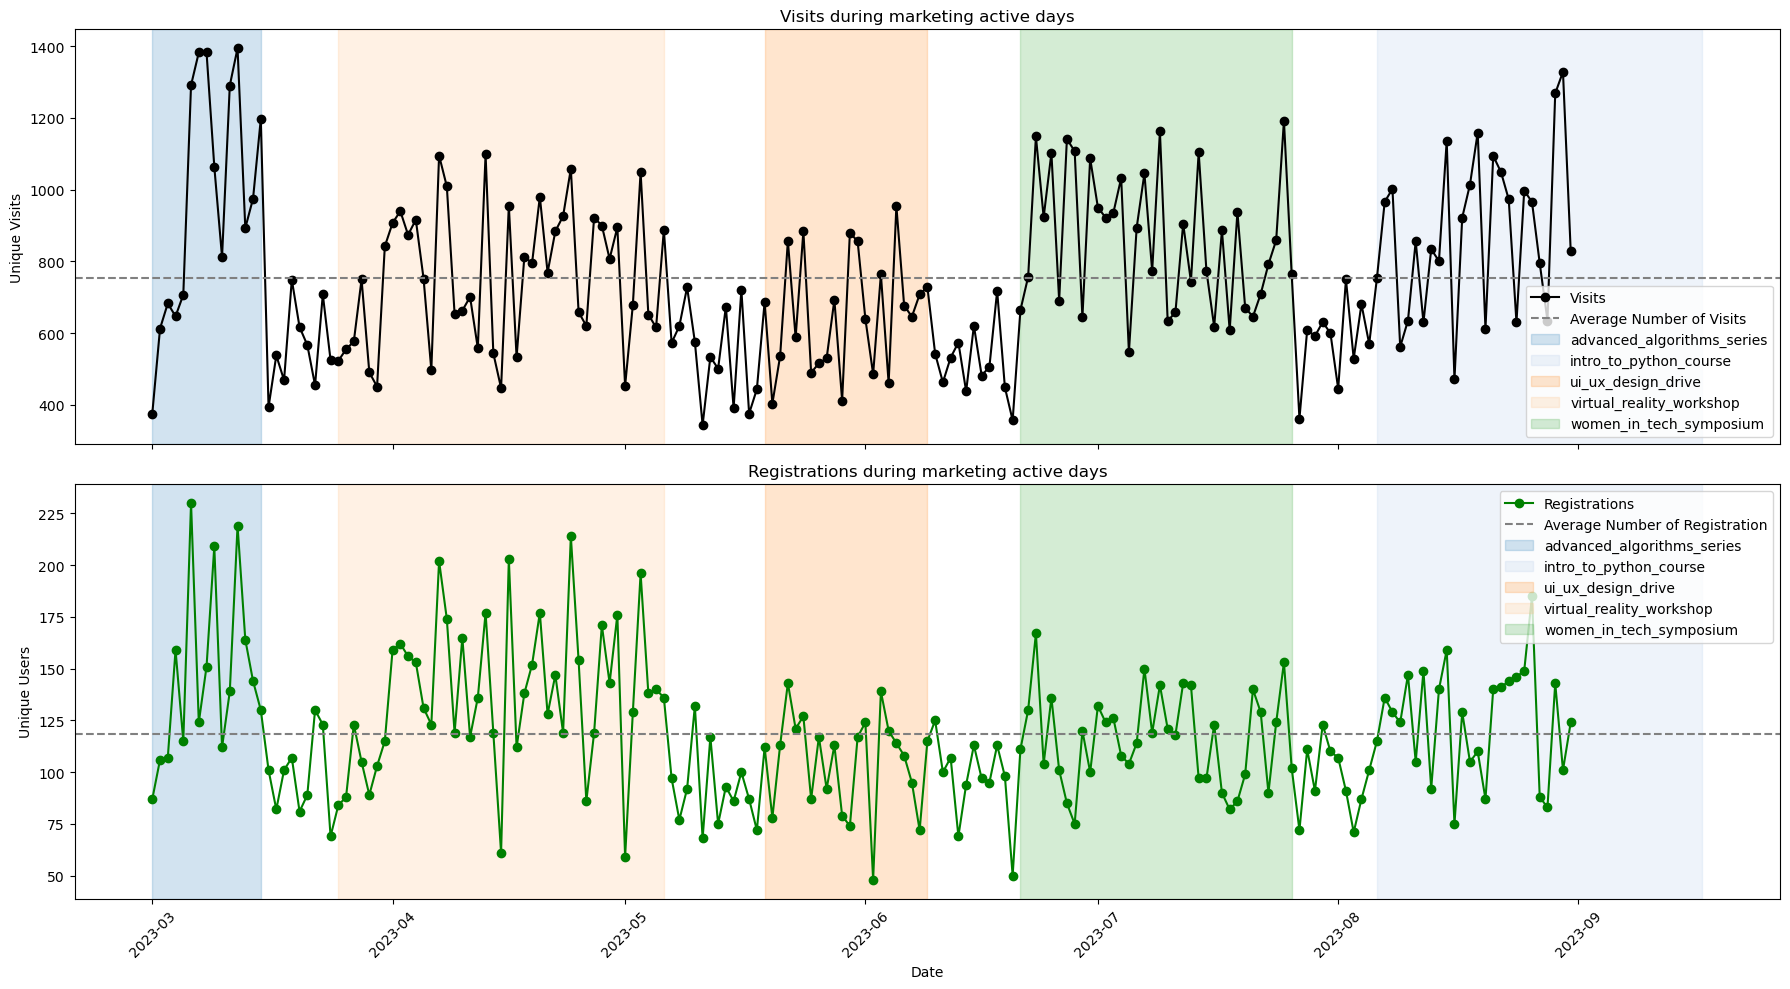

In [91]:
visits_daily = conv_ads_df.groupby('date_group')['visits'].sum().reset_index()
regs_daily = conv_ads_df.groupby('date_group')['registrations'].sum().reset_index()
ads_by_day = ads_df.groupby(['group_date', 'utm_campaign'])['cost'].sum().reset_index()
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
axes[0].plot(visits_daily['date_group'], visits_daily['visits'],
             marker='o', color='black', label='Visits')
avg_visits = visits_daily['visits'].mean()
axes[0].axhline(avg_visits, linestyle='--', color='gray',
                label='Average Number of Visits')
colors = plt.cm.tab20.colors
for i, (campaign, group) in enumerate(ads_by_day.groupby('utm_campaign')):
    start = group['group_date'].min()
    end = group['group_date'].max()
    axes[0].axvspan(start, end, alpha=0.2,
                    color=colors[i % len(colors)], label=campaign)

axes[0].set_title("Visits during marketing active days")
axes[0].set_ylabel("Unique Visits")
axes[0].legend()
axes[1].plot(regs_daily['date_group'], regs_daily['registrations'],
             marker='o', color='green', label='Registrations')
avg_regs = regs_daily['registrations'].mean()
axes[1].axhline(avg_regs, linestyle='--', color='gray',
                label='Average Number of Registration')
for i, (campaign, group) in enumerate(ads_by_day.groupby('utm_campaign')):
    start = group['group_date'].min()
    end = group['group_date'].max()
    axes[1].axvspan(start, end, alpha=0.2,
                    color=colors[i % len(colors)], label=campaign)
axes[1].set_title("Registrations during marketing active days")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Unique Users")
axes[1].legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./charts/visits_regs_with_ads.png")
plt.show()

In [92]:
#print(df_result.head())
print(conv_ads_df.head())


   date_group platform  visits  registrations  conversion  \
0  2023-03-01  android      75             61   81.333333   
1  2023-03-01      ios      22             18   81.818182   
2  2023-03-01      web     279              8    2.867384   
3  2023-03-02  android      67             59   88.059701   
4  2023-03-02      ios      31             24   77.419355   

                 utm_campaign   cost  
0  advanced_algorithms_series  212.0  
1  advanced_algorithms_series  212.0  
2  advanced_algorithms_series  212.0  
3  advanced_algorithms_series  252.0  
4  advanced_algorithms_series  252.0  


In [93]:
from dotenv import load_dotenv
import os

load_dotenv()

API_URL = os.getenv('API_URL')
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')

print("API_URL:", API_URL)
print("DATE_BEGIN:", DATE_BEGIN)
print("DATE_END:", DATE_END)

API_URL: https://data-charts-api.hexlet.app
DATE_BEGIN: 2023-03-01
DATE_END: 2023-09-01
